In [18]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as scs
import statsmodels as smm
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

# 1. Import Dataset and States (from R)

In [19]:
train=pd.read_csv('raw_train_daily.csv')
test=pd.read_csv('raw_test_daily.csv')
train_state=pd.read_csv('train_state.csv')

train=train.iloc[:,1:] #
test=test.iloc[:,1:] #
train_state=train_state.iloc[:,1:] #

In [20]:
#Original state are labelled as 2 for low and 1 for high (R)
#Now high state==1, low position state==0
train_state=2-train_state 
train_state.head()

,x
0,1
1,1
2,1
3,1
4,1


# 2. Feature generation and lag contemporary variables

In [21]:
def feature(train):
    train=train.drop(labels='Signal',axis=1)
    train=train.dropna()
    
    #1. Slope: since SPX proven to be the most predictive from Max's work
    train['SPX_1w_chg']=train['SPX']/train['SPX'].shift(1)-1 #weekly pct change
    train['SPX_2w_chg']=train['SPX']/train['SPX'].shift(2)-1 

    #2. Spread: for those highly correlated interest rates
    train['Spread_Libor_1YOIS']=train['Libor 1Y']-train['1Y OIS']

    #3. Lag: for comtemporary variables
    l=['AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S','AM_L', 'AM_S', 'Lev_L', 'Lev_S'] 
    newl=['last_'+s for s in l]
    train[newl]=train[l].shift(1)   #TS ARIMA potential
    train=train.drop(labels=l,axis=1)
    #remove signal becasue it's very sparse

    #4. Var

    #5. Cumsum

    #Comments: 1.daily signal 2.time series singal
    #train=train.drop(labels='Signal',axis=1)
    
    return train.dropna() #less the first two rows

In [22]:
#Benchmark: OLS
train=feature(train)
test=feature(test)
train_state=train_state.iloc[2:,]

In [23]:
#make sure number of weeks are the same
train.shape[0]==train_state.shape[0]

True

In [24]:
X=train.drop(columns = ['Time','AM_NetPos'])
y=train['AM_NetPos']
time_train=train['Time']

X_test=test.drop(columns = ['Time','AM_NetPos'])
y_test=test['AM_NetPos']
time_test=test['Time']

# 3. State as label in logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression
y_state=np.array(train_state).reshape(len(train_state))
clf = LogisticRegression(random_state=0,max_iter=10000).fit(X.values, y_state)

In [27]:
#expected to see 1,1 because the initial states are high
clf.predict(X.iloc[:2, :].values)

array([1, 1])

In [28]:
#Test set: predicting the states for high/low
clf.predict(X_test.values)

array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# 4. Different models for High/Low state: OLS

**4.1 Model**

In [29]:
from sklearn.linear_model import LinearRegression
X_high=X.iloc[np.where(train_state==1)[0]]
y_high=y.iloc[np.where(train_state==1)[0]]
X_low=X.iloc[np.where(train_state==0)[0]]
y_low=y.iloc[np.where(train_state==0)[0]]

OLS_high = LinearRegression().fit(X_high, y_high)
OLS_low = LinearRegression().fit(X_low, y_low)

**4.2 Evaluation: Training**

In [30]:
def evaluate(y,y_pred,title='Result'):
    mse=np.mean((y-y_pred)**2)
    mae=np.mean(np.abs(y-y_pred))
    ape=np.mean(np.abs((y-y_pred)/y))
    print(title,':')
    print('MSE is {}'.format(mse))
    print('MAE is {}'.format(mae))
    print('Average Percentage Error is {}'.format(ape))

In [31]:
#Train
y_pred_high=OLS_high.predict(X_high)
y_pred_low=OLS_low.predict(X_low)

evaluate(y_high,y_pred_high,title='OLS High Train')
print('\n')
evaluate(y_low,y_pred_low,title='OLS Low Train')

OLS High Train :
MSE is 42209391.34587564
MAE is 5065.279542289808
Average Percentage Error is 0.02440539701660164


OLS Low Train :
MSE is 47140897.041206755
MAE is 5551.680701932552
Average Percentage Error is 0.06797047320768808


**4.3 Inference: Test**

In [32]:
#Test
test_state=clf.predict(X_test.values)
X_high_test=X_test.iloc[np.where(test_state==1)[0]]
X_low_test=X_test.iloc[np.where(test_state==0)[0]]
y_high_test=y_test.iloc[np.where(test_state==1)[0]]
y_low_test=y_test.iloc[np.where(test_state==0)[0]]

y_pred_test_high=OLS_high.predict(X_high_test)
y_pred_test_low=OLS_low.predict(X_low_test)

In [33]:
evaluate(y_high_test,y_pred_test_high,title='OLS High Test')
print('\n')
evaluate(y_low_test,y_pred_test_low,title='OLS Low Test')

OLS High Test :
MSE is 146546226.18194008
MAE is 9671.018874344907
Average Percentage Error is 0.053735674985933304


OLS Low Test :
MSE is 2374013765.7847123
MAE is 44998.41327802125
Average Percentage Error is 0.3820737076831408


In [55]:
#merge the test prediction into a single test_pred array
y_pred_test=y_test.copy()
y_pred_test.iloc[np.where(test_state==0)[0]]=y_pred_test_low
y_pred_test.iloc[np.where(test_state==1)[0]]=y_pred_test_high
evaluate(y_test,y_pred_test,title='OLS Test')

OLS Test :
MSE is 1963121695.3725498
MAE is 38481.70945598387
Average Percentage Error is 0.3215064977681218


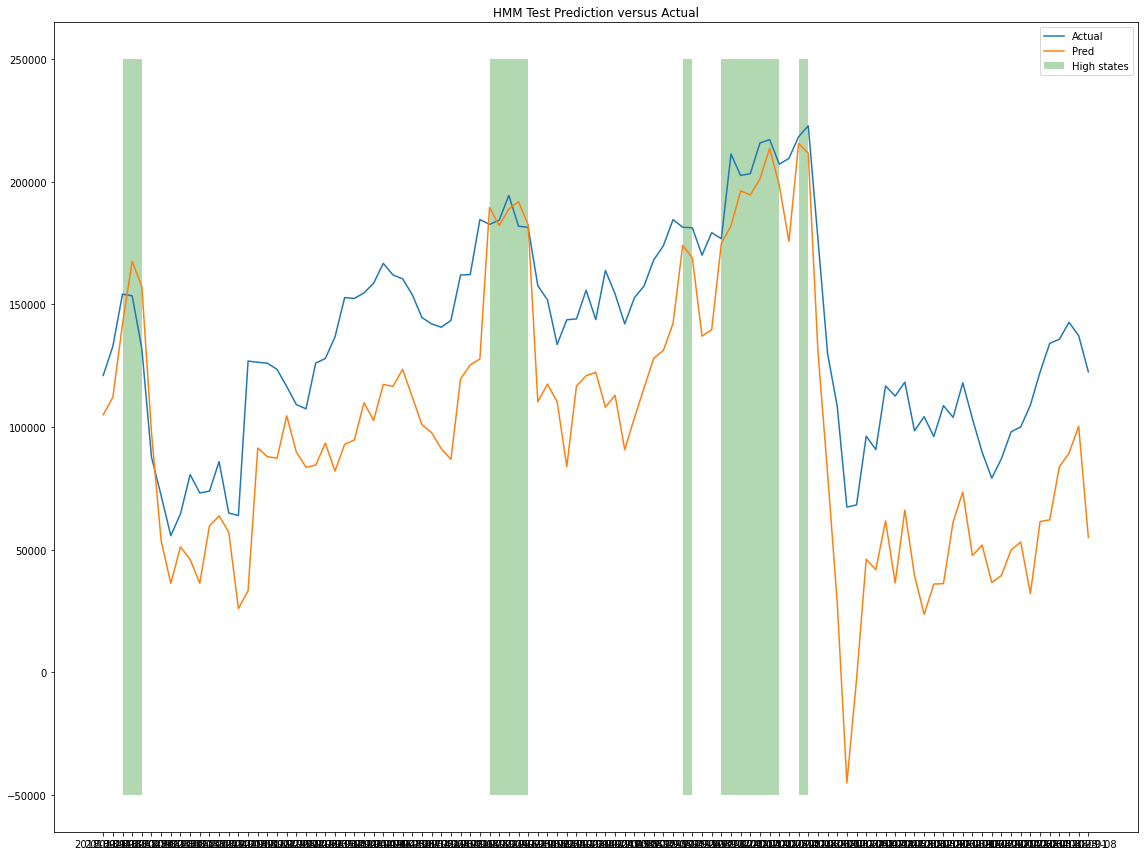

In [58]:
plt.figure(figsize=(16,12))
plt.plot(time_test,y_test,label='Actual')
plt.plot(time_test,y_pred_test,label='Pred')
plt.fill_between(time_test,-50000,250000,
                 where=(test_state==1),facecolor='green', alpha=0.3,label='High states')

plt.title('HMM Test Prediction versus Actual')
plt.legend()
plt.tight_layout()
plt.savefig('HMM Test Prediction',dpi=300)
plt.show()

Model performs well in the 'high' state with a 5.3% test AAPE as labelled in shaded green area but the performance drops significantly in the 'low' state with 38% test AAPE. Overall the model produces a test 32% AAPE. This indicated that indentifying the states which the positioning is in can be potentially helpful but the states needs more specific recognition.

In [59]:
def tsplot(y, lags=None, figsize = (10,8), style = 'bmh',title='Time Series of Log Ret',save='False'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (1,0))
        y.plot(ax = ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags = lags, ax=acf_ax,alpha = 0.05)
        sm.qqplot(y, line = 's', ax=qq_ax)
        qq_ax.set_title('QQ PLot')
        plt.tight_layout()
        if save:
            plt.savefig(title,dpi=300)
    return

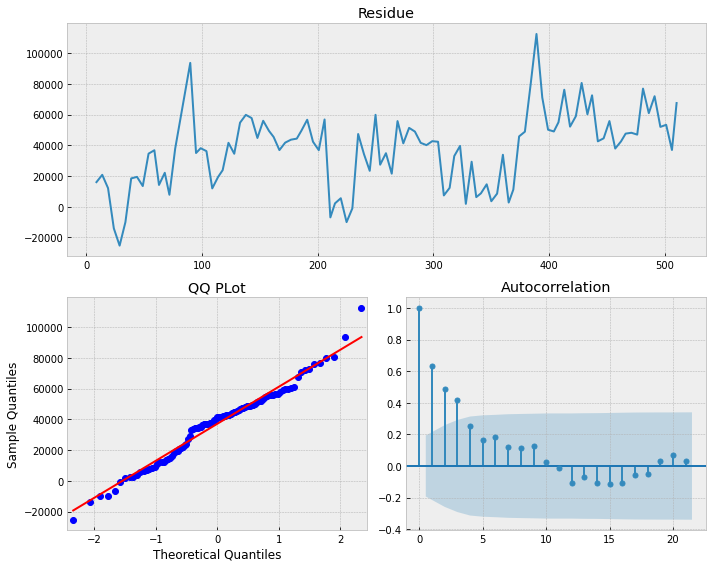

In [61]:
#look at the residue
tsplot(y_test-y_pred_test,title='Residue',save='True')

The prediction error has serial correlation up to lag 3. Residues are mostly positive indicating the model tends to over-estimate.

Error in high/low
y as diff